# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05656

Name: SHREYA SRIRAM

Email: 2025aa0565@wilp.bits-pilani.ac.in

Date: 3-Feb-2026

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from collections import Counter
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
import cv2

### 1.1 Dataset Selection and Loading

TODO: Load your chosen dataset

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs', 
    split=['train[:85%]', 'train[85%:]'], 
    as_supervised=True, 
    with_info=True,
    try_gcs=True  
)

In [8]:
label_counts = Counter()
for image, label in tfds.as_numpy(ds_train):
    label_counts[int(label)] += 1

min_c = min(label_counts.values())
max_c = max(label_counts.values())
avg_c = sum(label_counts.values()) / len(label_counts)

2026-02-03 00:19:00.636873: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-03 00:19:03.119200: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Cats VS Dogs"
dataset_source = "Tensorflow datasets"
n_samples = int(ds_info.splits['train'].num_examples)  # TODO: Total number of images
n_classes = int(ds_info.features['label'].num_classes)  # TODO: Number of classes
samples_per_class = f"min: {min_c}, max: {max_c}, avg: {avg_c:.1f}"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

In [10]:
# Primary metric selection
primary_metric = "accuracy"
metric_justification = """Accuracy is chosen because this is a balanced, binary classification problem (cats vs dogs) where both classes are expected to have similar representation and the typical misclassification costs are symmetric; accuracy therefore gives a direct measure of overall correctness. However, accuracy can be misleading if class imbalance or asymmetric costs appear, so we will also monitor precision, recall and the confusion matrix during training and evaluation to detect class-specific failures. If one error type becomes more costly (e.g., false negatives are worse than false positives) we will prioritise recall or the F1-score and inspect precision-recall curves; for threshold-independent comparison we will report ROC AUC. In summary: use accuracy as the primary, high-level metric for model selection, while keeping precision/recall/F1 and curve-based metrics for deeper, class-sensitive analysis."""


In [11]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Cats VS Dogs
Source: Tensorflow datasets
Total Samples: 23262
Number of Classes: 2
Samples per Class: min: 9835, max: 9938, avg: 9886.5
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Accuracy is chosen because this is a balanced, binary classification problem (cats vs dogs) where both classes are expected to have similar representation and the typical misclassification costs are symmetric; accuracy therefore gives a direct measure of overall correctness. However, accuracy can be misleading if class imbalance or asymmetric costs appear, so we will also monitor precision, recall and the confusion matrix during training and evaluation to detect class-specific failures. If one error type becomes more costly (e.g., false negatives are worse than false positives) we will prioritise recall or the F1-score and inspect precision-recall curves; for threshold-independent comparison we will report ROC AUC. In summary: use accuracy as the prim

### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

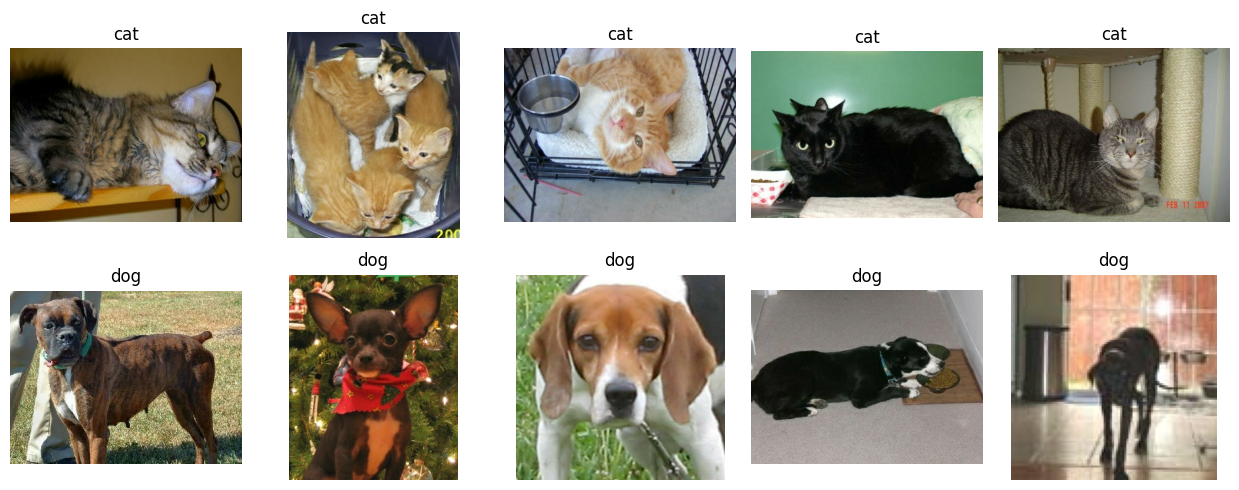

In [12]:
class_names = ds_info.features['label'].names  

def show_samples_per_class(ds, class_names, samples_per_class=5):
    collected = {i: [] for i in range(len(class_names))}

    for image, label in ds:
        lbl = int(label.numpy())
        if len(collected[lbl]) < samples_per_class:
            collected[lbl].append(image)
        if all(len(collected[i]) == samples_per_class for i in collected):
            break

    plt.figure(figsize=(samples_per_class * 2.5, len(class_names) * 2.5))
    for cls_idx, cls_name in enumerate(class_names):
        for j, img in enumerate(collected[cls_idx]):
            plt.subplot(len(class_names), samples_per_class,
                        cls_idx * samples_per_class + j + 1)
            plt.imshow(img.numpy())
            plt.axis('off')
            plt.title(cls_name)
    plt.tight_layout()
    plt.show()

show_samples_per_class(ds_train, class_names)


Class counts: {'dog': 9835, 'cat': 9938}


2026-02-03 00:19:15.597684: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


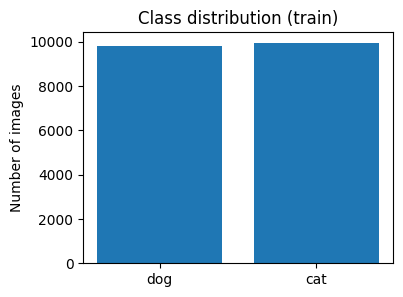

In [13]:
label_counts = Counter()
for _, label in ds_train:
    label_counts[int(label.numpy())] += 1

print("Class counts:", {class_names[k]: v for k, v in label_counts.items()})

plt.figure(figsize=(4, 3))
plt.bar(
    [class_names[i] for i in label_counts.keys()],
    [label_counts[i] for i in label_counts.keys()]
)
plt.ylabel("Number of images")
plt.title("Class distribution (train)")
plt.show()


In [14]:
def show_image_stats(ds, num_samples=1000):
    means, stds = [], []
    shapes = []
    for i, (img, _) in enumerate(ds):
        if i >= num_samples:
            break
        img_f = tf.cast(img, tf.float32) / 255.0
        means.append(tf.reduce_mean(img_f).numpy())
        stds.append(tf.math.reduce_std(img_f).numpy())
        shapes.append(img.shape)

    print(f"Samples used: {len(means)}")
    print(f"Mean pixel value: {np.mean(means):.4f}")
    print(f"Std pixel value:  {np.mean(stds):.4f}")
    if shapes:
        print(f"Example original shape: {shapes[0]}")

show_image_stats(ds_train, num_samples=1000)


Samples used: 1000
Mean pixel value: 0.4527
Std pixel value:  0.2327
Example original shape: (262, 350, 3)


### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    # Resize to consistent size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, depth=2)  


In [16]:
train_ds = (ds_train
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .shuffle(10000)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

test_ds = (ds_test
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

In [17]:
# REQUIRED: Document your split
train_test_ratio = "85/15"
train_samples = len(ds_train)  # TODO: Number of training samples
test_samples = len(ds_test)  # TODO: Number of test samples

In [18]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 85/15
Training Samples: 19773
Test Samples: 3489


### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [19]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    # TODO: Implement your CNN architecture
    # Must include Global Average Pooling
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # MANDATORY: Global Average Pooling (NO Flatten)
        layers.GlobalAveragePooling2D(),

        # Output layer with Softmax
        layers.Dense(n_classes, activation='softmax')
    ])
    model.summary()
    return model

In [20]:
# TODO: Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

/Users/shreya/miniconda3/envs/tf_cnn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# TODO: Compile model
# For Keras: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# For PyTorch: define optimizer and loss function
custom_cnn.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

### 2.2 Train Custom CNN

In [22]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [ ]:
# TODO: Train your model
# For Keras: history = custom_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
# For PyTorch: write training loop
history = custom_cnn.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    batch_size=32, validation_split=0.1
)

Epoch 1/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 245s 392ms/step - accuracy: 0.6028 - loss: 0.6503 - val_accuracy: 0.6285 - val_loss: 0.6240
Epoch 2/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 274s 441ms/step - accuracy: 0.6699 - loss: 0.5995 - val_accuracy: 0.6913 - val_loss: 0.5742
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 28912s 47s/step - accuracy: 0.7000 - loss: 0.5768 - val_accuracy: 0.7068 - val_loss: 0.5749
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 3318s 5s/step - accuracy: 0.7160 - loss: 0.5600 - val_accuracy: 0.7297 - val_loss: 0.5378
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 240s 386ms/step - accuracy: 0.7268 - loss: 0.5466 - val_accuracy: 0.7392 - val_loss: 0.5347
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.7352 - loss: 0.5332 - val_accuracy: 0.7386 - val_loss: 0.5203
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 567s 913ms/step - accuracy: 0.7453 - loss: 0.5197 - val_accuracy: 0.7670 - val_loss: 0.5039
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 353s 568ms/step - accuracy: 0.7524 - los

In [ ]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [ ]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = float(history.history['loss'][0]) # TODO: Get from training history (first epoch)
custom_cnn_final_loss = float(history.history['loss'][-1])  # TODO: Get from training history (last epoch)

In [ ]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

In [ ]:
print("\nCUSTOM CNN EVALUATION")

### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = custom_cnn.predict(images, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))          # predicted class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1)) # true class indices (one-hot -> int)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
# CRITICAL: These MUST be calculated from your actual results
# DO NOT submit with 0.0 values - autograder will detect this
# REQUIRED: Calculate all 4 metrics

custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')

In [ ]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Train loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom CNN - Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
cm = confusion_matrix(y_true, y_pred)  
print("Confusion matrix:\n", cm)

In [ ]:

images_batch, labels_batch = next(iter(test_ds))

probs_batch = custom_cnn.predict(images_batch, verbose=0)
pred_indices = np.argmax(probs_batch, axis=1)
true_indices = np.argmax(labels_batch.numpy(), axis=1)

plt.figure(figsize=(12, 6))
num_show = min(8, images_batch.shape[0])

for i in range(num_show):
    plt.subplot(2, 4, i + 1)
    img = images_batch[i].numpy()
    plt.imshow(img)
    plt.axis('off')
    pred_label = class_names[pred_indices[i]]
    true_label = class_names[true_indices[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)

plt.suptitle("Custom CNN - Sample Predictions", fontsize=12)
plt.tight_layout()
plt.show()


### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")

In [ ]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "TODO: ResNet18/ResNet50/VGG16/VGG19"

In [ ]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    # TODO: Load pre-trained model without top layers
    # TODO: Freeze base layers
    # TODO: Add Global Average Pooling + custom classification head
    # TODO: Compile model
    pass

In [ ]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [ ]:
# REQUIRED: Count layers and parameters
frozen_layers = 0  # TODO: Count frozen layers
trainable_layers = 0  # TODO: Count trainable layers
total_parameters = 0  # TODO: Total parameters
trainable_parameters = 0  # TODO: Trainable parameters only

In [ ]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")

In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [ ]:
# Track training time
tl_start_time = time.time()

In [ ]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop

In [ ]:
tl_training_time = time.time() - tl_start_time

In [ ]:
# REQUIRED: Track initial and final loss
tl_initial_loss = 0.0  # TODO: Get from training history (first epoch)
tl_final_loss = 0.0  # TODO: Get from training history (last epoch)

In [ ]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# REQUIRED: Calculate all 4 metrics
tl_accuracy = 0.0  # TODO: accuracy_score(y_test, y_pred)
tl_precision = 0.0  # TODO: precision_score(y_test, y_pred, average='macro')
tl_recall = 0.0  # TODO: recall_score(y_test, y_pred, average='macro')
tl_f1 = 0.0  # TODO: f1_score(y_test, y_pred, average='macro')

In [ ]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 4.1 Metrics Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [ ]:
print(comparison_df.to_string(index=False))

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here